In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import time
from numpy import array
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_log_error, confusion_matrix
from sklearn.ensemble import RandomForestRegressor

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import LSTM
from keras.layers import Embedding
from math import sin, pi
from random import *

Using TensorFlow backend.


In [2]:
sin(0.5*pi)

1.0

In [3]:
measurements = []
for i in range(0,2000):
    measurements.append(sin(0.1*i) + uniform(-0.1, 0.1))
measurements

[-0.047917405555368164,
 0.09068222318591662,
 0.2540677573379937,
 0.22996146726283467,
 0.3172049683753934,
 0.4007756115953198,
 0.49179627605855886,
 0.721846477140542,
 0.7572032218279618,
 0.7344132210041477,
 0.7866620664803525,
 0.9464635879938919,
 0.9006695833152205,
 0.9008042680357715,
 1.0365178264049932,
 0.9815825744949549,
 1.0989334339528092,
 1.0037697473376475,
 1.067524917072594,
 0.8621640219992244,
 0.9945532391702985,
 0.8443801698774874,
 0.8312204904586883,
 0.6893641712403311,
 0.7495831810553999,
 0.6225317684756909,
 0.5431037892257566,
 0.3819246748984163,
 0.267249605534587,
 0.2968242628874229,
 0.08759741014800415,
 0.010775540137661563,
 -0.011514552867003328,
 -0.16656867854573415,
 -0.23067251516836906,
 -0.26066492197680113,
 -0.3541653063824075,
 -0.5613787249242232,
 -0.5648296266789092,
 -0.6859385229764274,
 -0.6729991073085033,
 -0.8696817872497963,
 -0.7935784207954254,
 -0.9461117831800059,
 -0.9274768987627662,
 -0.9357336490764374,
 -0.97145

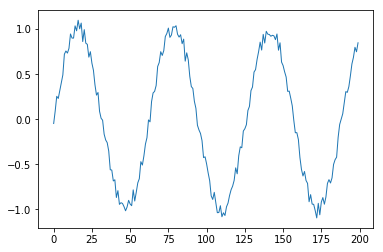

In [5]:
plt.plot(measurements[:200], label='measurements', linewidth=1)
plt.show()

In [6]:
X_train = measurements[:1000]
X_val = measurements[1000:]


print(X_val)

[-0.4943532696701542, -0.42948105630575506, -0.3380238892346985, -0.2619351800056421, -0.133772491466079, 0.0156944374840999, 0.024199715510287906, 0.25218452180817347, 0.19973461702528972, 0.35944962078614245, 0.39654739352187074, 0.4863058176269175, 0.5418688425046626, 0.7056995808287699, 0.7966544526280753, 0.9179595061999132, 0.8347350999473901, 0.8489874842420673, 0.9319608851012124, 0.9787318697626916, 0.901435758595037, 0.9585267638787827, 1.088217846375347, 0.9360192435768645, 0.9894026244563625, 0.8308093347235653, 0.887549184905082, 0.8730773305085557, 0.7004585309566946, 0.6047993465871555, 0.6587063788743692, 0.5240071142369157, 0.4307739468032056, 0.3661961033756354, 0.3124212181826004, 0.19360617427415067, 0.05443868652029589, -0.04474370025333324, -0.0638990368404927, -0.25013300525842863, -0.4014845883121413, -0.4438641322176843, -0.5234440210010082, -0.49644057452540136, -0.652459948135218, -0.8036282064650998, -0.7292400210040717, -0.8199435090521219, -0.9607635462278

In [8]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [9]:
raw_seq = list(X_train)
# choose a number of time steps
n_steps = 10
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [10]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
990/990 [==============================] - 6s 6ms/step - loss: 0.2974
Epoch 2/200
990/990 [==============================] - 1s 1ms/step - loss: 0.0911
Epoch 3/200
990/990 [==============================] - 1s 1ms/step - loss: 0.0404
Epoch 4/200
990/990 [==============================] - 1s 1ms/step - loss: 0.0155
Epoch 5/200
990/990 [==============================] - 1s 1ms/step - loss: 0.0069
Epoch 6/200
990/990 [==============================] - 1s 1ms/step - loss: 0.0069
Epoch 7/200
990/990 [==============================] - 1s 1ms/step - loss: 0.0067
Epoch 8/200
990/990 [==============================] - 1s 1ms/step - loss: 0.0062
Epoch 9/200
990/990 [==============================] - 1s 955us/step - loss: 0.0056
Epoch 10/200
990/990 [==============================] - 1s 977us/step - loss: 0.0061 0s - loss: 0.006 - ETA: 0s - loss: 0.
Epoch 11/200
990/

990/990 [==============================] - 1s 1ms/step - loss: 0.0052
Epoch 92/200
990/990 [==============================] - 1s 1ms/step - loss: 0.0053
Epoch 93/200
990/990 [==============================] - 1s 1ms/step - loss: 0.0051
Epoch 94/200
990/990 [==============================] - 1s 1ms/step - loss: 0.0048
Epoch 95/200
990/990 [==============================] - 1s 1ms/step - loss: 0.0049
Epoch 96/200
990/990 [==============================] - 1s 945us/step - loss: 0.0049
Epoch 97/200
990/990 [==============================] - 1s 1ms/step - loss: 0.0051
Epoch 98/200
990/990 [==============================] - 1s 1ms/step - loss: 0.0055
Epoch 99/200
990/990 [==============================] - 1s 1ms/step - loss: 0.0055
Epoch 100/200
990/990 [==============================] - 1s 1ms/step - loss: 0.0048
Epoch 101/200
990/990 [==============================] - 1s 1ms/step - loss: 0.0050
Epoch 102/200
990/990 [==============================] - 1s 1ms/step - loss: 0.0050
Epoch 103/20

990/990 [==============================] - 1s 977us/step - loss: 0.0047
Epoch 187/200
990/990 [==============================] - 1s 990us/step - loss: 0.0050
Epoch 188/200
990/990 [==============================] - 1s 986us/step - loss: 0.0046
Epoch 189/200
990/990 [==============================] - 1s 960us/step - loss: 0.0044
Epoch 190/200
990/990 [==============================] - 1s 971us/step - loss: 0.0044
Epoch 191/200
990/990 [==============================] - 1s 988us/step - loss: 0.0046 0s - loss: 0.0
Epoch 192/200
990/990 [==============================] - 1s 986us/step - loss: 0.0050
Epoch 193/200
990/990 [==============================] - 1s 996us/step - loss: 0.0049
Epoch 194/200
990/990 [==============================] - 1s 958us/step - loss: 0.0045
Epoch 195/200
990/990 [==============================] - 1s 995us/step - loss: 0.0044
Epoch 196/200
990/990 [==============================] - 1s 995us/step - loss: 0.0046
Epoch 197/200
990/990 [==============================

In [11]:
X_v, y_v = split_sequence(list(X_val), n_steps)

In [12]:
X_validation = X_v.reshape((X_v.shape[0], X_v.shape[1], n_features))

In [13]:
yhat = model.predict(X_validation, verbose=0)
print(yhat)

[[ 4.25346702e-01]
 [ 5.02783358e-01]
 [ 5.72970271e-01]
 [ 6.36304855e-01]
 [ 7.18078971e-01]
 [ 7.99609423e-01]
 [ 8.98630679e-01]
 [ 9.32957113e-01]
 [ 9.73041892e-01]
 [ 9.84637141e-01]
 [ 1.00350809e+00]
 [ 9.88678813e-01]
 [ 9.80333209e-01]
 [ 9.77023840e-01]
 [ 9.57540393e-01]
 [ 9.43889499e-01]
 [ 9.07915175e-01]
 [ 8.70017111e-01]
 [ 8.23265553e-01]
 [ 7.30142653e-01]
 [ 6.33372188e-01]
 [ 5.52401781e-01]
 [ 4.46816713e-01]
 [ 3.76215756e-01]
 [ 2.74684459e-01]
 [ 2.18312442e-01]
 [ 1.15281269e-01]
 [ 1.38112698e-02]
 [-7.74901733e-02]
 [-1.69608578e-01]
 [-3.06206018e-01]
 [-4.25935388e-01]
 [-5.35109282e-01]
 [-6.26364529e-01]
 [-6.84757948e-01]
 [-7.39691615e-01]
 [-8.04787278e-01]
 [-8.52909029e-01]
 [-8.98461461e-01]
 [-9.39678013e-01]
 [-9.73854482e-01]
 [-9.95457888e-01]
 [-1.02018189e+00]
 [-1.02275050e+00]
 [-9.98285413e-01]
 [-9.94079113e-01]
 [-9.54576313e-01]
 [-8.87526631e-01]
 [-8.63388181e-01]
 [-8.13597202e-01]
 [-7.34533310e-01]
 [-6.54209018e-01]
 [-5.8189064

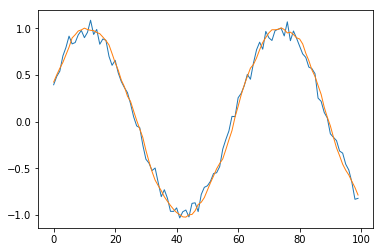

In [17]:
plt.plot(y_v[:100], label='true', linewidth=1)
plt.plot(yhat[:100], label='predicted', linewidth=1)
plt.show()

In [18]:
yhat_train = model.predict(X, verbose=0)
print(yhat_train)

[[ 8.39865088e-01]
 [ 8.83396268e-01]
 [ 9.37143803e-01]
 [ 9.83090401e-01]
 [ 9.93773937e-01]
 [ 1.01349592e+00]
 [ 1.01209497e+00]
 [ 1.01049101e+00]
 [ 1.01327133e+00]
 [ 1.02232516e+00]
 [ 9.61103678e-01]
 [ 9.23847616e-01]
 [ 8.74808550e-01]
 [ 8.17014098e-01]
 [ 6.98051810e-01]
 [ 6.51223779e-01]
 [ 5.50424337e-01]
 [ 4.82247561e-01]
 [ 3.58232796e-01]
 [ 2.62188584e-01]
 [ 1.50229469e-01]
 [ 5.75776771e-02]
 [-5.69198504e-02]
 [-1.35230631e-01]
 [-2.56518126e-01]
 [-3.43821734e-01]
 [-4.21231329e-01]
 [-4.89495426e-01]
 [-5.85762143e-01]
 [-6.70546293e-01]
 [-7.36079216e-01]
 [-7.93399215e-01]
 [-8.60790372e-01]
 [-9.01118934e-01]
 [-9.48400021e-01]
 [-9.84218240e-01]
 [-9.97581065e-01]
 [-1.00177860e+00]
 [-1.01181543e+00]
 [-1.00486660e+00]
 [-9.77630436e-01]
 [-9.39359963e-01]
 [-9.21609342e-01]
 [-8.51731956e-01]
 [-8.31119239e-01]
 [-7.88618565e-01]
 [-7.18936205e-01]
 [-6.48772717e-01]
 [-5.34730315e-01]
 [-4.37387794e-01]
 [-3.42232913e-01]
 [-2.39648923e-01]
 [-1.3951543

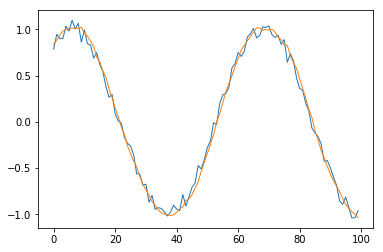

In [21]:
plt.plot(y[:100], label='true', linewidth=1)
plt.plot(yhat_train[:100], label='predicted', linewidth=1)
plt.show()